In [1]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='solarizedd')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='notebook', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interactive, HBox, VBox
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler as normalizer
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, curdoc
from bokeh.models import Label, Span, VBar, LinearAxis, ColumnDataSource, Plot
from multiprocessing import Pool
from IPython.display import clear_output 
from seaborn import heatmap

output_notebook()
plt.rcParams['figure.figsize'] = [15, 8]
proc_data = "../data/processed/covid/"

Loading BokehJS ...

In [3]:
covid = pd.read_csv(proc_data+"owid-covid-proc.csv", index_col=None, parse_dates=['date'],
                   usecols=['iso_code', 'date', 'new_cases','new_deaths', 'new_tests', 
                            'population', 'total_tests', 'total_cases', 'total_deaths'])

policy = pd.read_csv(proc_data+"policy_data.csv", index_col='record_id', 
                     dtype={'domestic_policy': bool, 'policy_id': int},
                     parse_dates=['date_announced','date_start','date_end'])

loc = pd.read_csv(proc_data+"allvars_location.csv", index_col='record_id', 
                  usecols=['record_id', 'ISO_A3', 'city', 'province'], dtype={'ISO_A3': str}, na_values={'ISO_A3': '-'})

desc = pd.read_csv(proc_data+"allvars_desc.csv", index_col='policy_id')

policy = policy.join(loc, on='record_id', how='left')

In [4]:
week_grp = pd.Grouper(key="date", freq='W')
norm_covid = covid.groupby(["iso_code", week_grp]).agg({'new_cases': 'sum', 'new_tests': 'sum', 'new_deaths': 'sum', 'population':'mean'})

In [5]:
def n(s):
    norm = normalizer()
    return norm.fit_transform(s.values.reshape(-1,1)).flatten()
norm_covid['new_cases'] = norm_covid['new_cases'].groupby(level=0).transform(n)
norm_covid['new_tests'] = norm_covid['new_tests'].groupby(level=0).transform(n)
norm_covid['new_deaths'] = norm_covid['new_deaths'].groupby(level=0).transform(n)

In [6]:
dm_nt_policy = policy.loc[policy.domestic_policy & (policy.init_country_level=='National')]
nplt = figure(plot_width=900, plot_height=600, x_axis_type='datetime')
case_line = nplt.line(color='red', legend_label='cases')
tests_line = nplt.line(color='blue', legend_label='tests')
death_line = nplt.line(color='black', legend_label='deaths')
start_span = Span(line_color='green', dimension='height')
end_span = Span(line_color='green', dimension='height')
nplt.add_layout(start_span)
nplt.add_layout(end_span)
plt_hndl = show(nplt, notebook_handle=True)

def draw_graph(c, p):
    pol = policy.loc[policy.policy_id==p]
    cvd = norm_covid.loc[c]
    
    start = pol.date_start.dropna().unique()
    if len(start) > 1:
        start = pol.loc[pol.date_start.notna()]
        start = start.loc[start.date_announced.idxmin()].date_start
    elif len(start) == 0:
        start = pol.date_announced.min()
    else:
        start = start[0]
        
    start = pd.Timestamp(start)
    
    end = pol.date_end.dropna().unique()
    
    if len(end) > 1:
        eop = pol.loc[pol.update_type=='End of Policy']
        if len(eop) == 1:
            end = eop[0]
        elif len(eop) > 1:
            end = eop.loc[eop.date_announced.idxmax()].date_end
        else:
            end = pol.loc[pol.date_end.notna()]
            end = end.loc[end.date_announced.idxmax()].date_end
        end = pd.Timestamp(end)
    elif len(end) == 0:
        end = None
    else:
        end = end[0]
        end = pd.Timestamp(end)
        
    l = desc.loc[int(p)].description
    if type(l) is pd.Series:
        l = l.iloc[0]
    desc_box.value = l
    
    case_line.data_source.data.update(y=cvd.new_cases, x=cvd.index)
    tests_line.data_source.data.update(y=cvd.new_tests, x=cvd.index)
    death_line.data_source.data.update(y=cvd.new_deaths, x=cvd.index)
    nplt.title.text = c
    
    start_span.update(location=start)
    end_span.update(location=end)
    
    push_notebook(handle=plt_hndl)
        
def cnt_sel(country):
    pol_w.options=pd.Series(dm_nt_policy.loc[dm_nt_policy.ISO_A3==country].policy_id.unique()).sort_values()
    draw_graph(country, pol_w.value)

def pol_sel(policy):
    draw_graph(cnt_w.value, policy)
    
cnt_w = widgets.Select(options=pd.Series(dm_nt_policy.ISO_A3.dropna().unique()).sort_values())
cnt_i = cnt_w.value
pol_w = widgets.Select(options=pd.Series(dm_nt_policy.loc[dm_nt_policy.ISO_A3==cnt_i].policy_id.unique()).sort_values())

cnt = widgets.interactive(cnt_sel, country=cnt_w)
pol = widgets.interactive(pol_sel, policy=pol_w)

desc_box = widgets.Textarea(disabled=False)
ui = HBox([cnt, pol, desc_box])

display(ui)

In [7]:
total_cases = covid.groupby('iso_code').filter(lambda x: x.population.notna().any() & x.total_cases.notna().any())
total_cases = total_cases.groupby('iso_code').apply(lambda x: x.total_cases.max()/(x.population.max()/10000)).rename('cases')

In [8]:
pt = policy.loc[policy.init_country_level=='National', ['ISO_A3', 'date_start', 'date_end', 'policy_id', 'type']]

In [9]:
def dt_filter(df):    
    start = np.any(~np.isnan(df.date_start.unique()))
    end = np.any(~np.isnan(df.date_end.unique()))
    return start and end

def td(df):
    start = df.date_start.min()
    end = df.date_end.min()
    return pd.Series(data=end-start, index=['duration'], dtype='timedelta64[D]')

def corr(df):
    df.index = df.index.droplevel(0)    
    c = total_cases.loc[total_cases.index.isin(df.index)].to_frame()
    d = c.merge(df, left_index=True, right_index=True).astype({'duration': 'timedelta64[D]'})
    d = d.corr()
    return d.loc['cases', 'duration']

In [10]:
dp = pt.groupby(['type', 'ISO_A3', 'policy_id']).filter(dt_filter).set_index(['type', 'ISO_A3', 'policy_id'])
dp = dp.groupby(level=[0,1,2]).apply(td).groupby(level=[0,1,2]).filter(lambda x: x >= pd.Timedelta(0, 'days'))
dp = dp.groupby(level=[0,1]).agg('sum')
dp = dp.groupby(level=0).filter(lambda x: len(x)>0)
c = dp.groupby(level=0).agg(corr).rename(columns={'duration': 'Correlation'}).sort_values(by='Correlation').dropna()
c.index.rename('Policy Type', inplace=True)

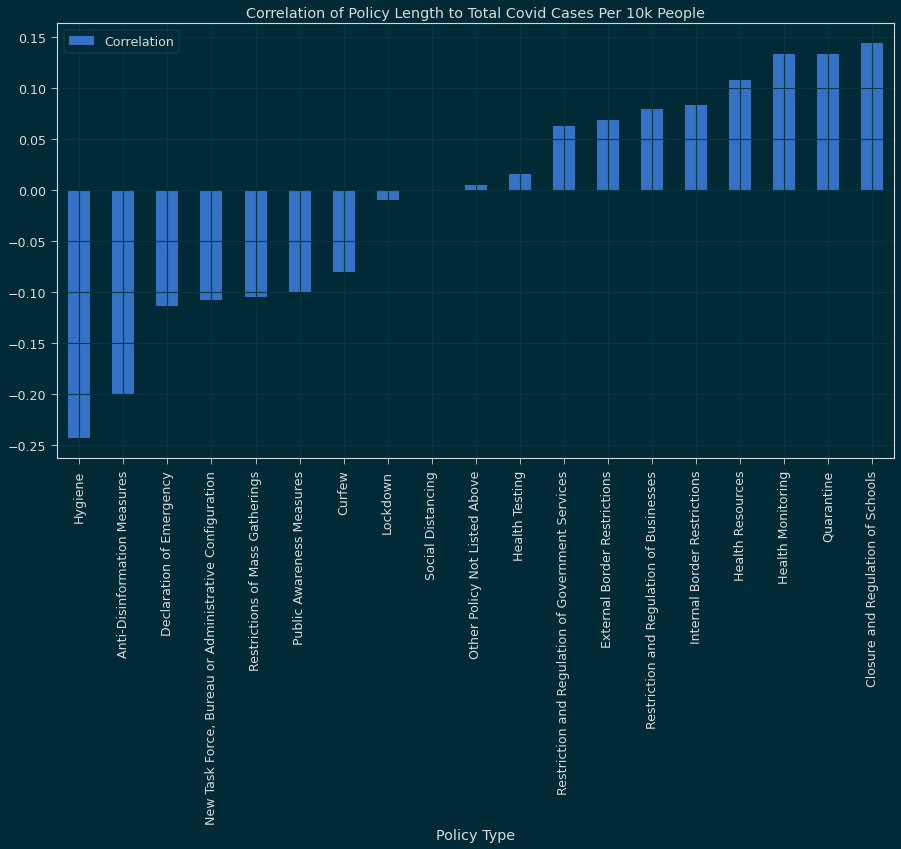

In [11]:
c.plot(kind='bar', title='Correlation of Policy Length to Total Covid Cases Per 10k People', grid=True);

In [12]:
reg_us = pd.read_csv("../data/processed/covid/us_regional_covid.csv", index_col=0,
                     parse_dates=['date'],
                    dtype={'confirmed': np.float64, 'deaths': np.float64, 
                           'recovered': np.float64, 'city': str, 'county': str,
                          'cruise_ship': bool, 'state': str})

In [13]:
us = policy.loc[policy.ISO_A3=='USA']

In [14]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [15]:
tp = us.target_province.transform(lambda x: us_state_abbrev[x] if x in us_state_abbrev else x)

In [16]:
us = us.drop("target_province", axis=1)
us = us.merge(tp, left_index=True, right_index=True)

In [17]:
us = us.loc[us.target_province.isin(reg_us.state.dropna().unique()) & (policy.init_country_level=="Provincial")]
us = us.loc[us.type.notna()]

In [18]:
p = us.groupby('policy_id').filter(lambda x: x.date_start.notna().any() & x.date_end.notna().any())
p = p.set_index(['type', 'ISO_A3', 'policy_id'])

In [19]:
p = p.groupby(level=[0, 1, 2]).apply(td)
p = p.groupby(level=[0,1,2]).filter(lambda x: x >= pd.Timedelta(0, 'days'))
p = dp.groupby(level=[0,1]).agg('sum')
p = dp.groupby(level=0).filter(lambda x: len(x)>0)
c = dp.groupby(level=0).agg(corr).rename(columns={'duration': 'Correlation'}).sort_values(by='Correlation').dropna()
c.index.rename('Policy Type', inplace=True)

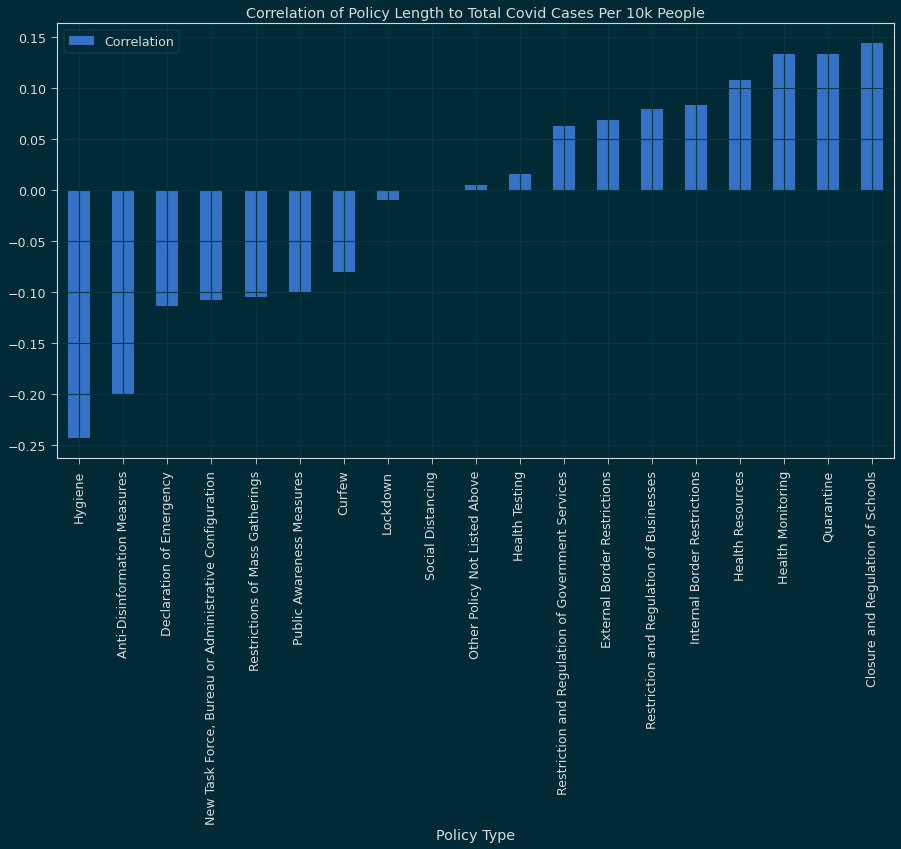

In [20]:
c.plot(kind='bar', title='Correlation of Policy Length to Total Covid Cases Per 10k People', grid=True);

In [21]:
cdt = covid[['iso_code', 'date', 'new_tests', 'new_cases', 'new_deaths', 'population']].set_index(['iso_code', 'date']).sort_index().drop(['INT', 'OWID_KOS', 'OWID_WRL'])

In [22]:
def p10k(df):
    pop = df.population
    
    t_p10k = df.new_tests/(pop/10000)
    c_p10k = df.new_cases/(pop/10000)
    d_p10k = df.new_deaths/(pop/10000)
    
    df = df.drop(['new_tests', 'new_cases', 'new_deaths', 'population'], axis=1)
    df['tests'] = t_p10k
    df['cases'] = c_p10k
    df['deaths'] = d_p10k
    
    return df
    
cdt_p10k = cdt.groupby(level=[0]).apply(p10k)

In [23]:
def xc(cnt2, cnt1):
    cols = cnt2.columns
    cnt_code = cnt2.index.get_level_values(0).unique()[0]
    out = pd.Series(index=cols, data=[np.NaN]*len(cols), dtype=np.float64, name=cnt_code)
    for c in cols:
        a = cnt2[c]
        b = cnt1[c]
        a = a[a>0]
        b = b[b>0]
        ag = (len(a.dropna()) > 2)
        bg = (len(b.dropna()) > 2)
        if ag and bg:
            am = a.index.min()
            bm = b.index.min()
            a = a[am:]
            b = b[bm:]
            if len(a.dropna()) > 2 and len(b.dropna()) > 2:
                a = pd.Series(a.values)
                b = pd.Series(b.values)
                out[c] = a.corr(b)
    return out

In [24]:
r = cdt_p10k.groupby(level=0).apply(lambda x: cdt_p10k.groupby(level=0).apply(xc, cnt1=x))

In [25]:
def xpose(df):
    df.index = df.index.droplevel(0)
    return df.transpose()

In [26]:
r1 = r.groupby(level=0).apply(xpose)

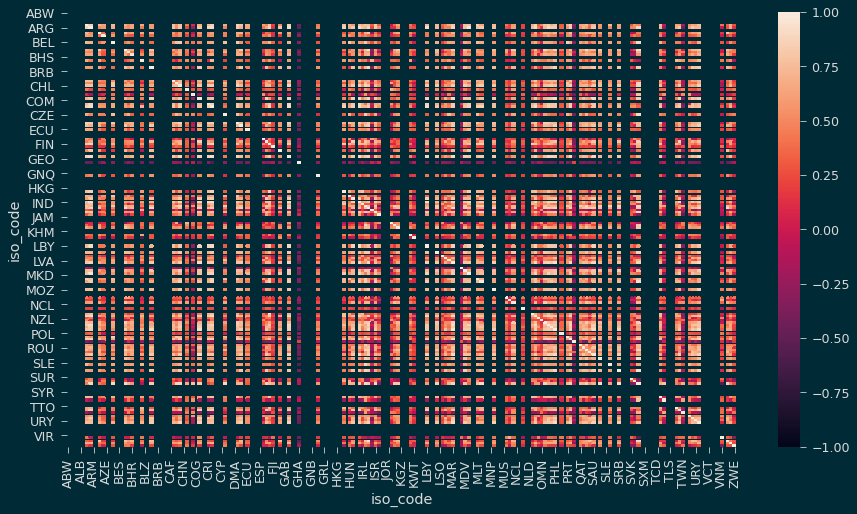

In [27]:
idx = pd.IndexSlice
tests = r1.loc[idx[:,'tests'], :]
tests.index = tests.index.droplevel(1)
heatmap(tests, vmin=-1, vmax=1);

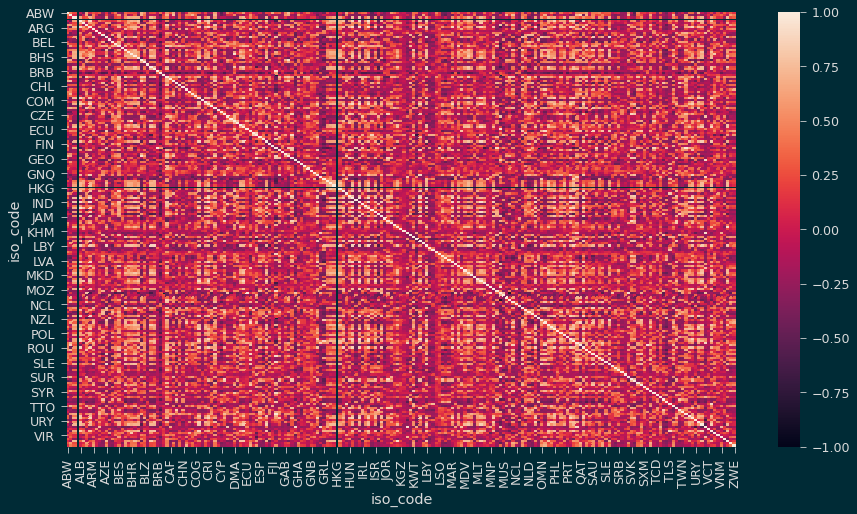

In [28]:
cases = r1.loc[idx[:,'cases'], :]
cases.index = cases.index.droplevel(1)
heatmap(cases, vmin=-1, vmax=1);

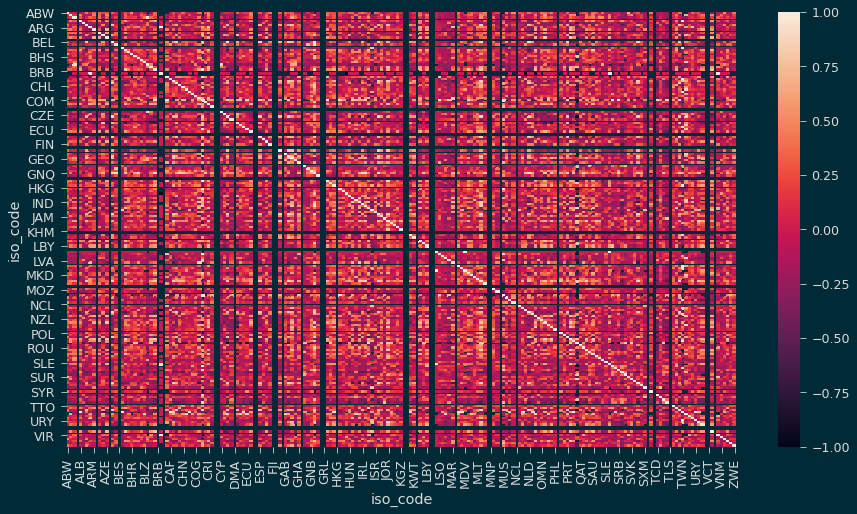

In [29]:
deaths = r1.loc[idx[:,'deaths'], :]
deaths.index = deaths.index.droplevel(1)
heatmap(deaths, vmin=-1, vmax=1);

In [30]:
a3_codes = pd.read_csv("../data/processed/isoa3_codes.csv", index_col='A3')
r1.index = r1.index.map(lambda x: (a3_codes.loc[x[0]].iloc[0], x[1]))
r1.columns = r1.columns.map(lambda x: a3_codes.loc[x][0])

In [31]:
cnt_w = widgets.Select(options=pd.Series(r1.index.get_level_values(0).unique()).sort_values())
meas_w = widgets.Select(options=pd.Series(r1.index.get_level_values(1).unique()).sort_values())
num_w = widgets.BoundedIntText(min=1, max=len(r1.index.get_level_values(0).unique()))
out = widgets.HTML()

def update():
    c = cnt_w.value
    m = meas_w.value
    n = num_w.value
    v = r1.loc[c,m].dropna()
    if c in v.index:
        v = v.drop(c)
    v = v.sort_values().tail(n)
    v = v.transpose().to_frame().transpose()
    vs = v.style.set_table_styles([{ 'selector': '*', 
                                    'props': [('background-color', 'white'), 
                                              ('color', 'black'), 
                                              ('border-left', '1px solid black'), 
                                              ('border-top', '1px solid black'),
                                              ('text-align', 'center')
                                             ]
                                   }])
    out.value = vs.render()

def cnt_sel(country):
    update()

def meas_sel(measure):
    update()

def num_sel(number):
    update()

cnt = widgets.interactive(cnt_sel, country=cnt_w)
meas = widgets.interactive(meas_sel, measure=meas_w)
num = widgets.interactive(num_sel, number=num_w)

upi = HBox([cnt, meas, num])
ui = VBox([upi, out])
display(ui)

In [32]:
p_types = policy.type.dropna().unique()

def dist_p(df):
    df = df.drop_duplicates('policy_id')
    t = df.type.dropna()
    l_p = len(t)
    d = pd.Series(index=p_types, data=[0]*len(p_types), dtype=np.float64)
    dist = t.value_counts()/l_p
    d[dist.index] = dist.values
    return d

p_dist = policy.groupby('ISO_A3').apply(dist_p)

In [33]:
p_msd = p_dist.agg(lambda x: p_dist.agg(lambda s: np.sqrt(((x-s)**2).sum()), axis=1), axis=1)

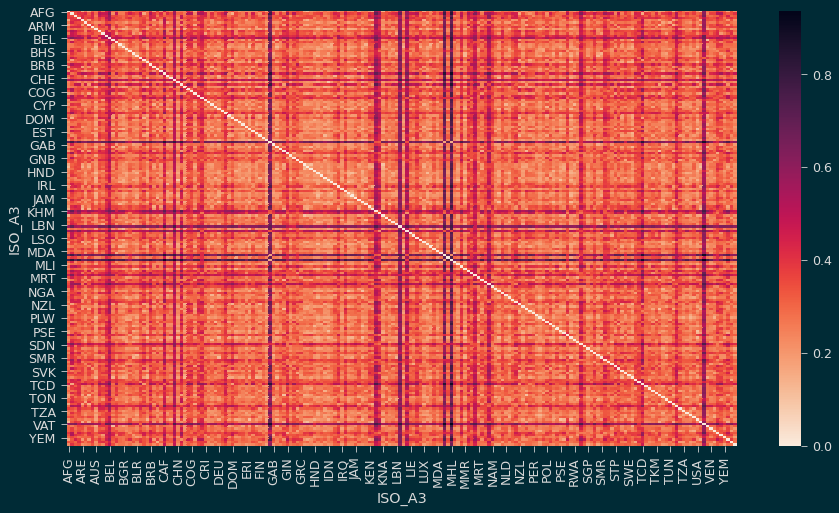

In [34]:
heatmap(p_msd, cmap=sns.cm.rocket_r);

In [35]:
c = cases.stack().rename('cases')
c.index = c.index.rename(['cnt1', 'cnt2'])
d = deaths.stack().rename('deaths')
d.index = d.index.rename(['cnt1', 'cnt2'])
p = p_msd.stack().rename('distance')
p.index = p.index.rename(['cnt1', 'cnt2'])

In [49]:
o = p.to_frame().merge(c, left_index=True, right_index=True, how='outer')
o = o.merge(d, left_index=True, right_index=True, how='outer')

In [50]:
o.corr()

,distance,cases,deaths
distance,1.000000,-0.138304,-0.094349
cases,-0.138304,1.000000,0.302036
deaths,-0.094349,0.302036,1.000000
